---
title: LSTM (and RNN, GRU) fitting
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

## The LSTM Unit

Before fitting LSTM models, let us first see how the basic LSTM unit in PyTorch (nn.LSTM) works (see \url{https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html} for details). The LSTM unit can be seen as a black box which (for a fixed $p$ and $k$) holds weight matrices $W_{ii}, W_{hi}, W_{if}, W_{hf}, W_{ig}, W_{hg}, W_{io}, W_{ho}$ and bias vectors $b_{ii}, b_{hi}, b_{if} b_{hf}, b_{ig}, b_{hg}, b_{io}, b_{ho}$. In order to create the LSTM unit, we only need to specify $p$ (this is the dimension of $x_t$ and will be referred to as the input size) and $k$ (this is the dimension of $h_t$ and will be referred to as the hidden size).

In [262]:
lstm_net = nn.LSTM(input_size = 1, hidden_size = 5, batch_first = True)  

The above code line will create a LSTM unit and will randomly initialize all its parameters $W_{ii}, W_{hi}, W_{if}, W_{hf}, W_{ig}, W_{hg}, W_{io}, W_{ho}$ and $b_{ii}, b_{hi}, b_{if} b_{hf}, b_{ig}, b_{hg}, b_{io}, b_{ho}$. Given a sequence $x_1, \dots, x_T$ for some $T$ (here each $x_t$ needs to be of dimension input_size), the LSTM unit will then use the formulas to compute $(c_1, h_1), \dots, (c_T, h_T)$. It will output $h_1, \dots, h_T$ as well as $(h_T, c_T)$. 

If we create two sets of input sequences $x_1, \dots, x_T$ and $\tilde{x}_1, \dots, \tilde{x}_T$, then the LSTM unit will use its formulae to output $h_1, \dots, h_T$ (as well as $(h_T, c_T)$) corresponding to $x_1, \dots, x_T$, as well as $\tilde{h}_1, \dots, \tilde{h}_T$, as well as $(\tilde{h}_T, \tilde{c}_T)$ corresponding to $\tilde{x}_1, \dots, \tilde{x}_T$. In general, if we send in $B$ input sequences (i.e., $B$ batches of input sequences), each sequence having length $T$ (and each $x$ in each sequence has dimension input_size), the output of the LSTM will correspond to $B$ sequences of length $T$ (each element of the sequence has dimension equal to hidden_size). The inputs and outputs can therefore both be treated as tensors. The 'batch_first = True' in the specification of lstm_net above indicates that the input tensor should have shape (B, T, input_size) and the output tensor will have shape (B, T, hidden_size). We will only use $B = 1$. 

In [264]:
#Let us create an input tensor for lstm_net:
input = torch.randn(1, 10, 1) 
#this input has one batch, which is a sequence x_1, \dots, x_10 of length 10. Each x_t is a scalar (input_size = 1). 
print(input)

output, (hn, cn) = lstm_net(input)

#output will have shape (1, 10, 5). It is a simply the sequence h_1, \dots, h_10 where each h_t is of dimension hidden_size = 5. 
print(output.shape)

print(hn.shape) #h_n is simply the hidden vector h_t corresponding to the last time (here t = 10). You can check that hn is identical to the last element of the output

print(cn.shape) #c_n is the cell state corresponding to the last output

print(output[:, 9, :])
print(hn)
#check that hn and output[:, 9, :] are identical

tensor([[[-0.6010],
         [ 0.5618],
         [-1.5536],
         [-0.8574],
         [ 0.0943],
         [ 0.6305],
         [ 0.8702],
         [ 0.6343],
         [-0.4735],
         [ 1.1954]]])
torch.Size([1, 10, 5])
torch.Size([1, 1, 5])
torch.Size([1, 1, 5])
tensor([[ 0.0266, -0.0024, -0.1292,  0.0224,  0.0120]],
       grad_fn=<SliceBackward0>)
tensor([[[ 0.0266, -0.0024, -0.1292,  0.0224,  0.0120]]],
       grad_fn=<StackBackward0>)


The weight matrices $W_{ii}, W_{if}, W_{ig}, W_{io}$ as well as $W_{hi}, W_{hf}, W_{hg}, W_{ho}$, and the biases $b_{ii}, b_{if}, b_{ig}, b_{io}$ as well as $b_{hi}, b_{hf}, b_{hg}, b_{ho}$ can be accessed as follows. 

In [265]:
print(lstm_net.weight_ih_l0.shape)
print(lstm_net.weight_ih_l0) #this contains the four weight matrices W_{ii}, W_{if}, W_{ig}, W_{io}

print(lstm_net.weight_hh_l0.shape)
print(lstm_net.weight_hh_l0) #this contains the four weight matrices W_{hi}, W_{hf}, W_{hg}, W_{ho}

print(lstm_net.bias_ih_l0.shape) 
print(lstm_net.bias_ih_l0)  #this contains  the four biases b_{ii}, b_{if}, b_{ig}, b_{io}

print(lstm_net.bias_hh_l0.shape) 
print(lstm_net.bias_hh_l0)  #this contains  the four biases b_{hi}, b_{hf}, b_{hg}, b_{ho}

#l0 here refers to the fact that there is a single LSTM layer. Sometimes, it is common to stack multiple LSTM units, in which case there will be weights and biases for each LSTM. We will only deal with a single LSTM layer

torch.Size([20, 1])
Parameter containing:
tensor([[ 0.2603],
        [-0.2236],
        [ 0.2664],
        [ 0.1512],
        [-0.2186],
        [-0.1205],
        [-0.1810],
        [ 0.1973],
        [-0.1793],
        [ 0.1518],
        [ 0.0319],
        [-0.3571],
        [-0.2811],
        [-0.3101],
        [ 0.2343],
        [ 0.0969],
        [-0.0112],
        [-0.2663],
        [-0.4431],
        [-0.1583]], requires_grad=True)
torch.Size([20, 5])
Parameter containing:
tensor([[-0.3423, -0.4448, -0.4265, -0.2921, -0.4348],
        [ 0.1394,  0.1673,  0.1803, -0.4452,  0.2765],
        [ 0.0872,  0.2287, -0.1099,  0.2148, -0.4241],
        [ 0.1523,  0.3546,  0.1880, -0.4215, -0.1255],
        [-0.0555,  0.2343, -0.1692,  0.0643, -0.1570],
        [-0.0710, -0.0089, -0.2568, -0.3104,  0.3692],
        [ 0.3757, -0.0135,  0.3871,  0.3446, -0.2817],
        [-0.1777, -0.3072,  0.1446,  0.0113, -0.0613],
        [ 0.3320, -0.1748, -0.2448, -0.3179, -0.2275],
        [ 0.4310, -0

The values that we see above for the weights and biases are randomly chosen initial values. Given some data, they will be trained so as to minimize some loss function. 

## Simulated Dataset One

Consider the following simple dataset. 

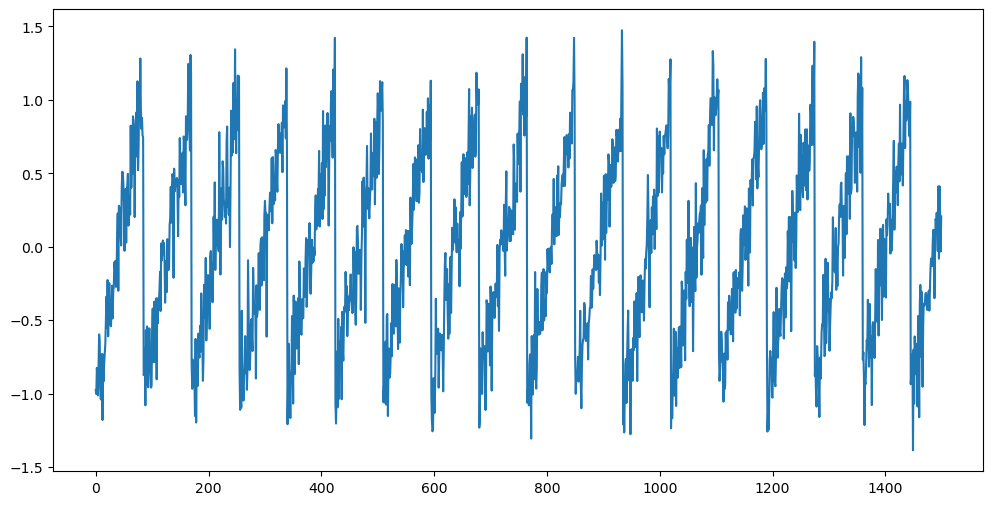

In [266]:
n = 1500
truelag = 85
rng = np.random.default_rng(seed = 0)
sig_noise = 0.2
eps = rng.normal(loc = 0, scale = sig_noise, size = n)
y_sim = np.full(shape = n, fill_value = -999.0)
y_sim[0:truelag] = np.linspace(-1, 1, truelag)
for i in range(truelag, n):
    y_sim[i] = y_sim[i - truelag] 
y_sim = y_sim + eps
plt.figure(figsize = (12, 6))
plt.plot(y_sim)
plt.show()

We first fit the AR($p$) model. If $p$ is taken to be smaller than the true lag which generated the data, the predictions will be quite poor. But the predictions are quite good when $p$ is exactly equal to the true lag. 

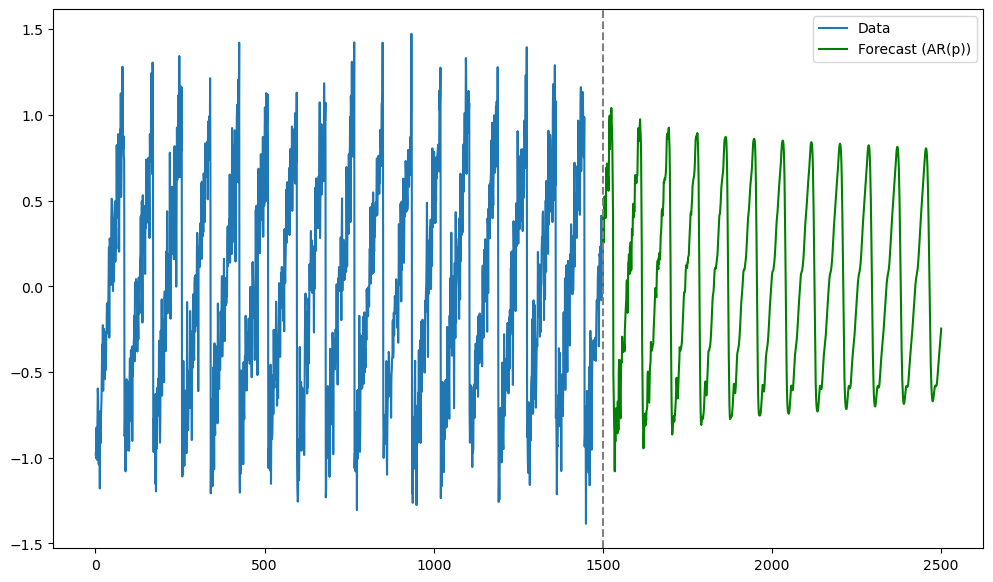

In [270]:
#Let us fit AR(p) with the truelag
#p = 60
p = truelag
ar = AutoReg(y_sim, lags = p).fit() 

n = len(y_sim)
tme = range(1, n+1)
n_future = 1000
tme_future = range(n+1, n+n_future+1)
fcast = ar.get_prediction(start = n, end = n+n_future-1).predicted_mean
plt.figure(figsize = (12, 7))
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, fcast, label = 'Forecast (AR(p))', color = 'green')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

Next we apply LSTM (and RNN). The first step is to create the input and output tensors. We scale the data before fitting models. 

In [271]:
mu, sig = y_sim.mean(), y_sim.std()
y_std = (y_sim - mu) / sig

X = torch.tensor(y_std[:-1], dtype=torch.float32)
Y = torch.tensor(y_std[1: ], dtype=torch.float32)

X = X.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)
Y = Y.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)

#unsqueeze(0) adds a dimension at the front (the batch dimension)
#unsqueeze(-1) adds a dimension at the end (the input dimension of x_t)

seq_len = X.size(1)
print(seq_len)

1499


We create the LSTM model class below. It consists of the LSTM unit which outputs $h_t$ (or $r_t$ in our notation) followed by a fully connected layer which outputs $\mu_t = \beta_0 + \beta^T h_t$. We take $k$ (below nh) to be 32. Increasing $k$ will make the parameter estimation process slower. 

In [272]:
class lstm_net(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=nh,
                           batch_first=True)
        self.fc  = nn.Linear(nh, 1)          
    def forward(self, x, hc=None):
        out, hc = self.rnn(x, hc)           
        out     = self.fc(out)               
        return out, hc

#lstm_net defined above has an LSTM unit followed by a linear unit ('fc' stands for fully-connected) which converts the output of the LSTM to a scalar (this scalar is mu_t in our notation)

torch.manual_seed(0)
np.random.seed(0)

nh = 32
model = lstm_net(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)


Training is done as follows. 

In [273]:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    model.train()
    opt.zero_grad()
    pred, _ = model(X)          
    loss = criterion(pred, Y)
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch  100/1000  |  loss = 0.291070
epoch  200/1000  |  loss = 0.196253
epoch  300/1000  |  loss = 0.177559
epoch  400/1000  |  loss = 0.173790
epoch  500/1000  |  loss = 0.169772
epoch  600/1000  |  loss = 0.165050
epoch  700/1000  |  loss = 0.163995
epoch  800/1000  |  loss = 0.158396
epoch  900/1000  |  loss = 0.156533
epoch 1000/1000  |  loss = 0.165788


Predictions are obtained as follows. 

In [274]:
model.eval()
with torch.no_grad():
    _, hc = model(X)
    preds = np.zeros(n_future, dtype=np.float32)
    last_in = torch.tensor([[y_std[-1]]], dtype=torch.float32)       
    for t in range(n_future):
        out, hc = model(last_in.view(1, 1, 1), hc)              # reuse hidden state
        next_val = out.squeeze().item()
        preds[t] = next_val
        last_in = torch.tensor([[next_val]], dtype=torch.float32)

Predictions are plotted below. 

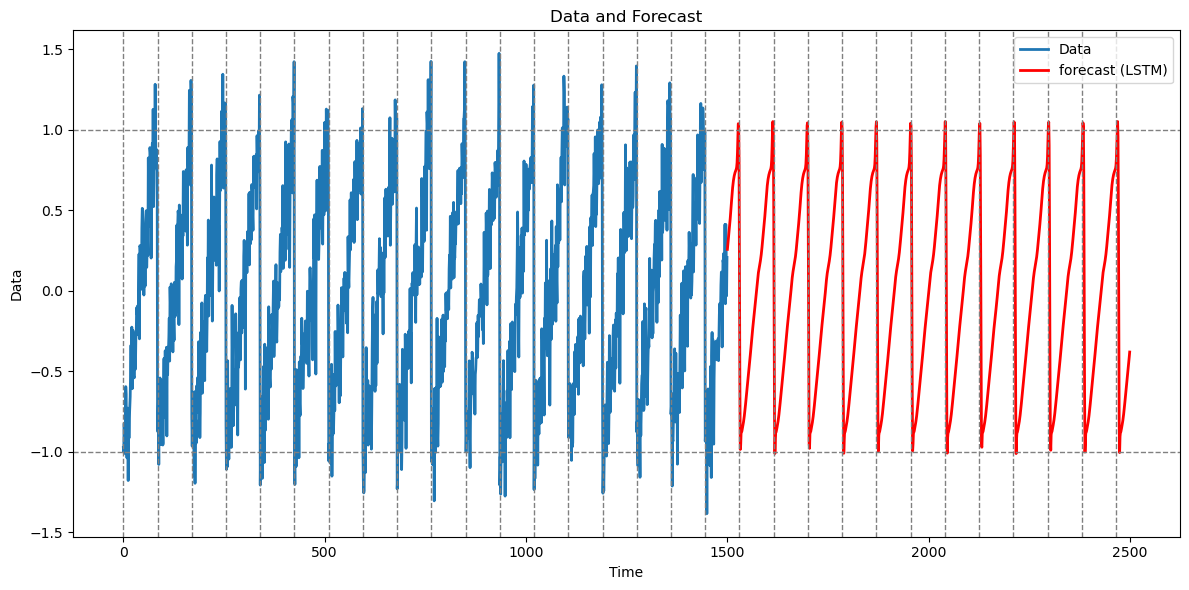

In [275]:
lstm_preds_orig = preds * sig + mu
tme_pred_axis = np.arange(n, n + n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y_sim, lw=2, label="Data")
plt.plot(tme_pred_axis, lstm_preds_orig, lw=2, color="r", label="forecast (LSTM)")
plt.xlabel("Time"); plt.ylabel("Data")
for t in range(0, n + n_future, truelag):
    plt.axvline(x=t, linestyle='--', color='gray', linewidth=1)
plt.axhline(y=1, linestyle='--', color='gray', linewidth=1)    
plt.axhline(y=-1, linestyle='--', color='gray', linewidth=1)    
plt.title("Data and Forecast")
plt.legend()
plt.tight_layout()
plt.show()

Let us now fit the RNN. 

In [276]:
class RNNReg(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.RNN(1, nh, nonlinearity="tanh", batch_first=True)
        self.fc  = nn.Linear(nh, 1)
    def forward(self, x, h=None):
        out, h = self.rnn(x, h)
        return self.fc(out), h

nh = 32
model = RNNReg(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(),lr = 1e-3)

In [277]:
n_epochs = 900
for epoch in range(1, n_epochs + 1):
    model.train()
    opt.zero_grad()
    pred, _ = model(X)           
    loss = criterion(pred, Y)
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch  100/900  |  loss = 0.293481
epoch  200/900  |  loss = 0.271486
epoch  300/900  |  loss = 0.263299
epoch  400/900  |  loss = 0.222172
epoch  500/900  |  loss = 0.199036
epoch  600/900  |  loss = 0.189352
epoch  700/900  |  loss = 0.188009
epoch  800/900  |  loss = 0.179842
epoch  900/900  |  loss = 0.176493


Below we obtain predictions for the RNN model. 

In [278]:
model.eval()
with torch.no_grad():
    _, h = model(X)                 
    preds = np.zeros(n_future, np.float32)
    last  = torch.tensor([[y_std[-1]]], dtype=torch.float32)
    for t in range(n_future):
        out, h = model(last.view(1,1,1), h)
        preds[t] = out.item()
        last = torch.tensor([[preds[t]]], dtype=torch.float32)


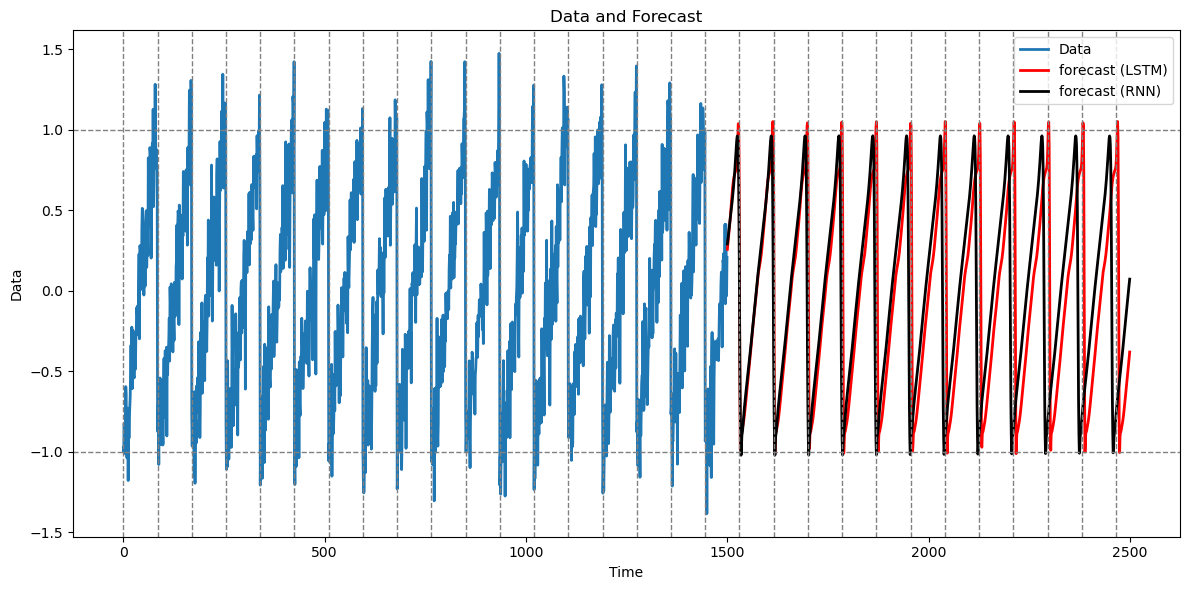

In [279]:
rnn_preds_orig = preds * sig + mu
tme_pred_axis = np.arange(n, n + n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y_sim, lw=2, label="Data")
plt.plot(tme_pred_axis, lstm_preds_orig, lw=2, color="red", label="forecast (LSTM)")
plt.plot(tme_pred_axis, rnn_preds_orig, lw=2, color="black", label="forecast (RNN)")
#plt.plot(tme_pred_axis, fcast, lw=2, color="green", label="forecast (AR)")

for t in range(0, n + n_future, truelag):
    plt.axvline(x=t, linestyle='--', color='gray', linewidth=1)

plt.axhline(y=1, linestyle='--', color='gray', linewidth=1)    
plt.axhline(y=-1, linestyle='--', color='gray', linewidth=1)    

plt.xlabel("Time"); plt.ylabel("Data")
plt.title("Data and Forecast")
plt.legend()
plt.tight_layout()
plt.show()

RNN gives predictions that are similar to the LSTM predictions. 

# Simulated Dataset Two

We now make two changes to the first simulation above. We increase the true lag. We also add noise slightly differently (noise is now added to the equation $y_t = y_{t-\text{truelag}} + \epsilon_t$). 

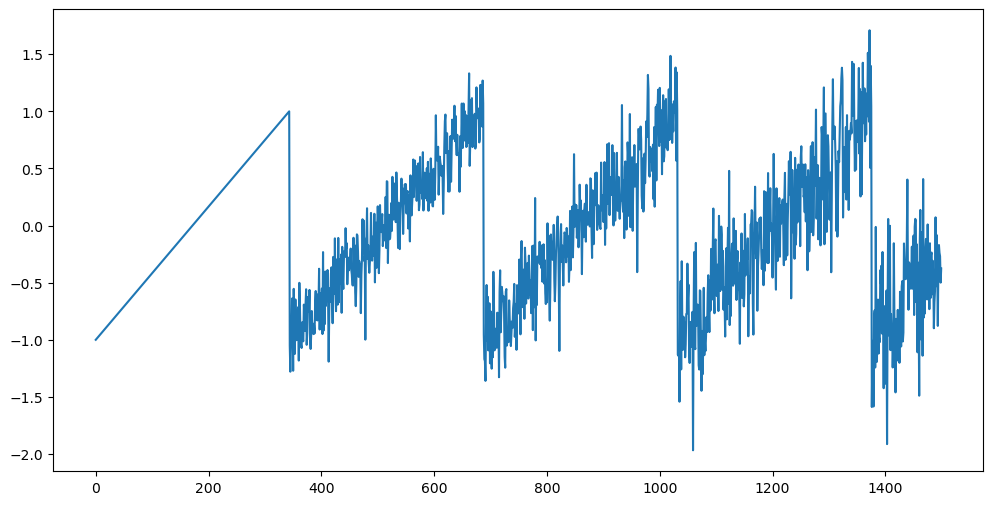

In [280]:
n = 1500
truelag = 344 
rng = np.random.default_rng(seed = 0)
sig_noise = 0.2
eps = rng.normal(loc = 0, scale = sig_noise, size = n)
y_sim = np.full(shape = n, fill_value = -999.0)
y_sim[0:truelag] = np.linspace(-1, 1, truelag)
for i in range(truelag, n):
    y_sim[i] = y_sim[i - truelag] + eps[i]
#y_sim = y_sim + eps
plt.figure(figsize = (12, 6))
plt.plot(y_sim)
plt.show()

This is a long range prediction problem. In this example, AR($p$) with $p$ taken to be the true lag gives very noisy predictions (as shown below) 

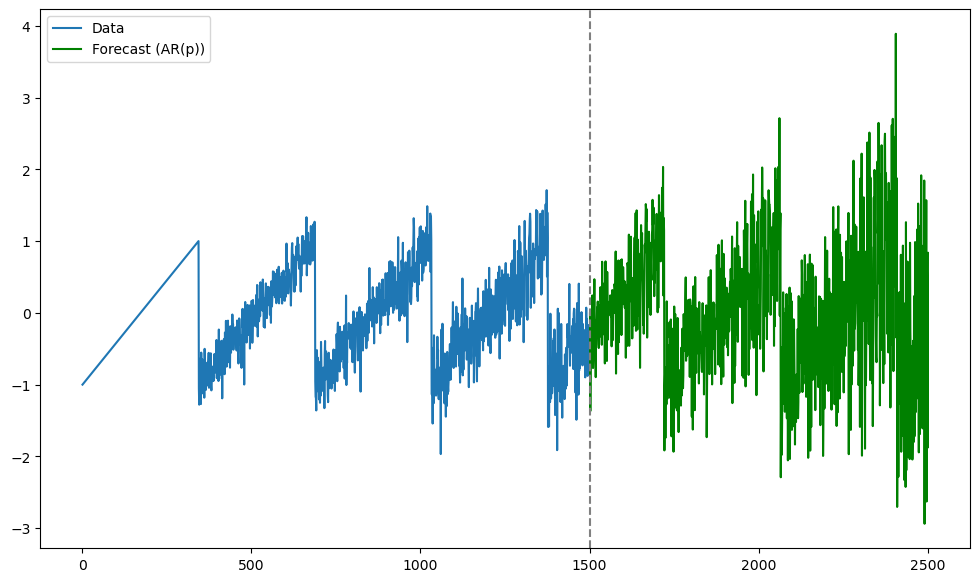

In [281]:
#Let us fit AR(p)
p = truelag
ar = AutoReg(y_sim, lags = p).fit() 

n = len(y_sim)
tme = range(1, n+1)
n_future = 1000
tme_future = range(n+1, n+n_future+1)
fcast = ar.get_prediction(start = n, end = n+n_future-1).predicted_mean
plt.figure(figsize = (12, 7))
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, fcast, label = 'Forecast (AR(p))', color = 'green')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

Let us see how the LSTM and RNN do.

In [282]:
mu, sig = y_sim.mean(), y_sim.std()
y_std = (y_sim - mu) / sig

X = torch.tensor(y_std[:-1], dtype=torch.float32)
Y = torch.tensor(y_std[1: ], dtype=torch.float32)

X = X.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)
Y = Y.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)

seq_len = X.size(1)
print(seq_len)

1499


Below is the LSTM again with 32 hidden size. 

In [283]:
class lstm_net(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=nh,
                           batch_first=True)
        self.fc  = nn.Linear(nh, 1)          
    def forward(self, x, hc=None):
        out, hc = self.rnn(x, hc)           
        out     = self.fc(out)               
        return out, hc

torch.manual_seed(0)
np.random.seed(0)

nh = 32
model = lstm_net(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)


Parameter estimation (training) is done below. 

In [284]:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    model.train()
    opt.zero_grad()
    pred, _ = model(X)          
    loss = criterion(pred, Y)
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch  100/1000  |  loss = 0.243756
epoch  200/1000  |  loss = 0.227583
epoch  300/1000  |  loss = 0.218399
epoch  400/1000  |  loss = 0.209345
epoch  500/1000  |  loss = 0.188405
epoch  600/1000  |  loss = 0.184548
epoch  700/1000  |  loss = 0.181477
epoch  800/1000  |  loss = 0.179199
epoch  900/1000  |  loss = 0.177259
epoch 1000/1000  |  loss = 0.175526


Below we obtain predictions. 

In [285]:
model.eval()
with torch.no_grad():
    _, hc = model(X)
    preds = np.zeros(n_future, dtype=np.float32)
    last_in = torch.tensor([[y_std[-1]]], dtype=torch.float32)  # (1, 1, 1) after view
    for t in range(n_future):
        out, hc = model(last_in.view(1, 1, 1), hc)              # reuse hidden state
        next_val = out.squeeze().item()
        preds[t] = next_val
        last_in = torch.tensor([[next_val]], dtype=torch.float32)

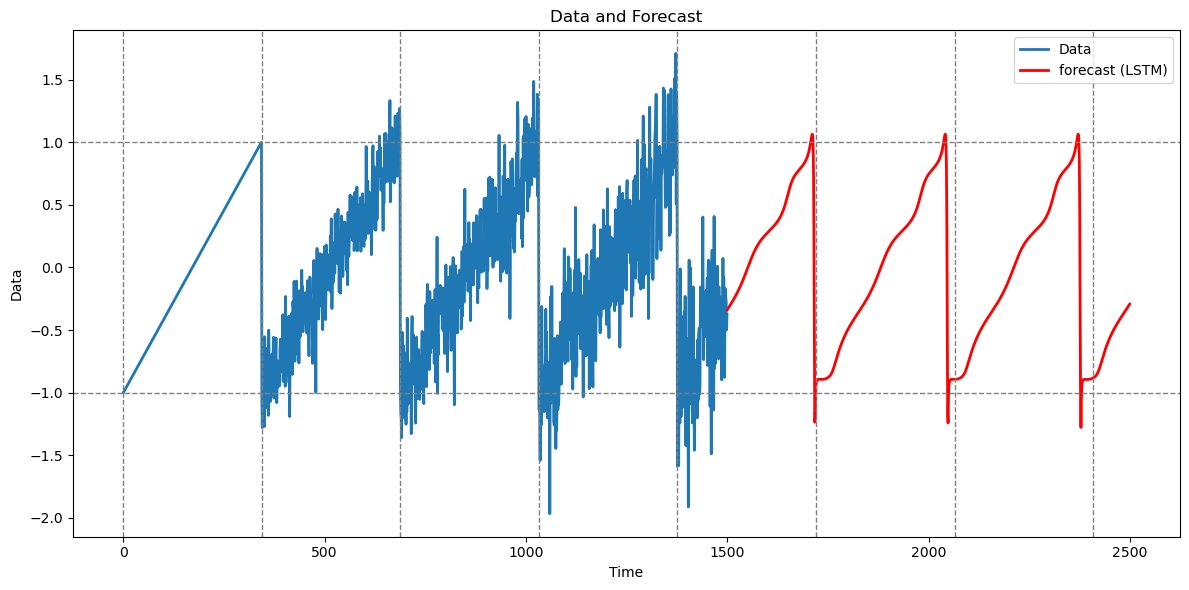

In [286]:
lstm_preds_orig = preds * sig + mu
tme_pred_axis = np.arange(n, n + n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y_sim, lw=2, label="Data")
plt.plot(tme_pred_axis, lstm_preds_orig, lw=2, color="r", label="forecast (LSTM)")
plt.xlabel("Time"); plt.ylabel("Data")
for t in range(0, n + n_future, truelag):
    plt.axvline(x=t, linestyle='--', color='gray', linewidth=1)
plt.axhline(y=1, linestyle='--', color='gray', linewidth=1)    
plt.axhline(y=-1, linestyle='--', color='gray', linewidth=1)    
plt.title("Data and Forecast")
plt.legend()
plt.tight_layout()
plt.show()

The predictions are decent. Note that the nature of the predictions (which seem quite clean) is quite different from the predictions given by the AR model (these were very noisy).  

RNN does not seem to work for this predictions as shown below (this is because of the lack of ability to capture long range dependencies). 

In [287]:
class RNNReg(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.RNN(1, nh, nonlinearity="tanh", batch_first=True)
        self.fc  = nn.Linear(nh, 1)
    def forward(self, x, h=None):
        out, h = self.rnn(x, h)
        return self.fc(out), h
    
torch.manual_seed(0)
np.random.seed(0)

nh = 50 #I could not find any value of nh for which the RNN is giving good predictions for this data
model = RNNReg(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(),lr = 1e-3)

In [288]:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    model.train()
    opt.zero_grad()
    pred, _ = model(X)           
    loss = criterion(pred, Y)
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch  100/1000  |  loss = 0.236083
epoch  200/1000  |  loss = 0.228475
epoch  300/1000  |  loss = 0.221912
epoch  400/1000  |  loss = 0.209255
epoch  500/1000  |  loss = 0.197350
epoch  600/1000  |  loss = 0.200900
epoch  700/1000  |  loss = 0.196046
epoch  800/1000  |  loss = 0.204768
epoch  900/1000  |  loss = 0.205714
epoch 1000/1000  |  loss = 0.182275


In [289]:
model.eval()
with torch.no_grad():
    _, h = model(X)                 
    preds = np.zeros(n_future, np.float32)
    last  = torch.tensor([[y_std[-1]]], dtype=torch.float32)
    for t in range(n_future):
        out, h = model(last.view(1,1,1), h)
        preds[t] = out.item()
        last = torch.tensor([[preds[t]]], dtype=torch.float32)


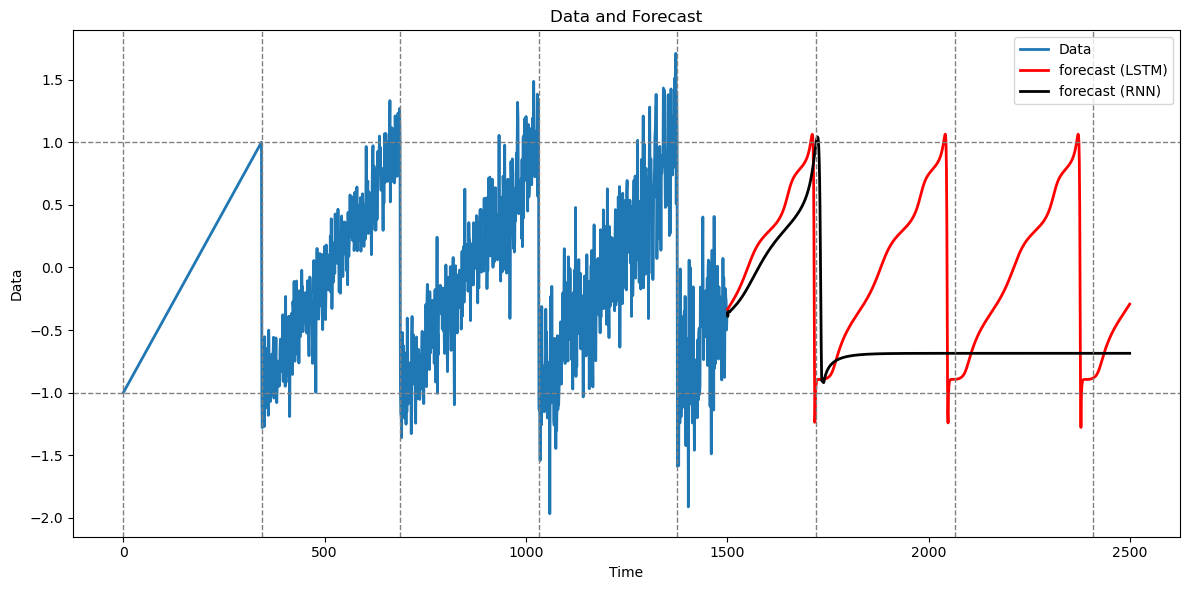

In [290]:
rnn_preds_orig = preds * sig + mu
tme_pred_axis = np.arange(n, n + n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y_sim, lw=2, label="Data")
plt.plot(tme_pred_axis, lstm_preds_orig, lw=2, color="red", label="forecast (LSTM)")
plt.plot(tme_pred_axis, rnn_preds_orig, lw=2, color="black", label="forecast (RNN)")

for t in range(0, n + n_future, truelag):
    plt.axvline(x=t, linestyle='--', color='gray', linewidth=1)

plt.axhline(y=1, linestyle='--', color='gray', linewidth=1)    
plt.axhline(y=-1, linestyle='--', color='gray', linewidth=1)    

plt.xlabel("Time"); plt.ylabel("Data")
plt.title("Data and Forecast")
plt.legend()
plt.tight_layout()
plt.show()

These RNN predictions seem decent initially but they deviate considerably from the LSTM predictions as we go further into the future. 

## Sunspots Data

Below we apply LSTM, RNN and GRU to obtain predictions for the sunspots dataset. 

        0     1    2  3  4
0  1700.5   8.3 -1.0 -1  1
1  1701.5  18.3 -1.0 -1  1
2  1702.5  26.7 -1.0 -1  1
3  1703.5  38.3 -1.0 -1  1
4  1704.5  60.0 -1.0 -1  1


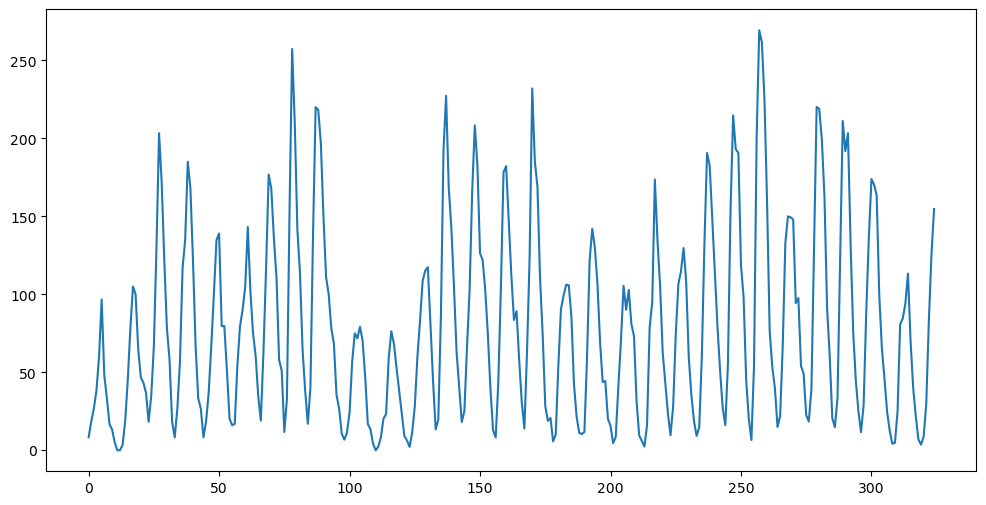

325


In [291]:
sunspots = pd.read_csv('SN_y_tot_V2.0.csv', header = None, sep = ';')
print(sunspots.head())
y = sunspots.iloc[:,1].values
n = len(y)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()
print(n)
n_future = 300

First we prepare $X$ and $Y$. 

In [292]:
mu, sig = y.mean(), y.std()
y_std = (y - mu) / sig

X = torch.tensor(y_std[:-1], dtype=torch.float32)
Y = torch.tensor(y_std[1: ], dtype=torch.float32)

X = X.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)
Y = Y.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)

seq_len = X.size(1)
print(seq_len)

324


We fit LSTM with the number of hidden units equaling 64. 

## LSTM for Sunspots

In [293]:
class lstm_net(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=nh,
                           batch_first=True)
        self.fc  = nn.Linear(nh, 1)          
    def forward(self, x, hc=None):
        out, hc = self.rnn(x, hc)           
        out     = self.fc(out)               
        return out, hc

torch.manual_seed(0)
np.random.seed(0)

nh = 64
model = lstm_net(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)


In [294]:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    model.train()
    opt.zero_grad()
    pred, _ = model(X)          
    loss = criterion(pred, Y)
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch  100/1000  |  loss = 0.178550
epoch  200/1000  |  loss = 0.089431
epoch  300/1000  |  loss = 0.063866
epoch  400/1000  |  loss = 0.042808
epoch  500/1000  |  loss = 0.036359
epoch  600/1000  |  loss = 0.030837
epoch  700/1000  |  loss = 0.025321
epoch  800/1000  |  loss = 0.021516
epoch  900/1000  |  loss = 0.017578
epoch 1000/1000  |  loss = 0.015462


In [295]:
model.eval()
with torch.no_grad():
    _, hc = model(X)
    preds = np.zeros(n_future, dtype=np.float32)
    last_in = torch.tensor([[y_std[-1]]], dtype=torch.float32)  # (1, 1, 1) after view
    for t in range(n_future):
        out, hc = model(last_in.view(1, 1, 1), hc)              # reuse hidden state
        next_val = out.squeeze().item()
        preds[t] = next_val
        last_in = torch.tensor([[next_val]], dtype=torch.float32)

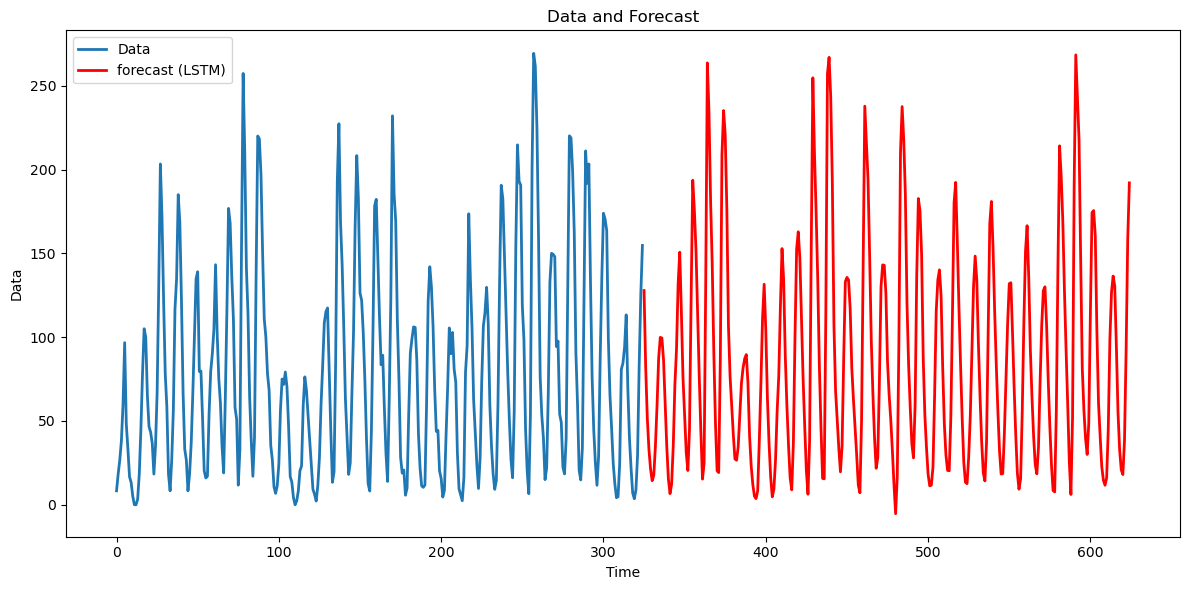

In [296]:
lstm_preds_orig = preds * sig + mu
tme_pred_axis = np.arange(n, n + n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y, lw=2, label="Data")
plt.plot(tme_pred_axis, lstm_preds_orig, lw=2, color="r", label="forecast (LSTM)")
plt.xlabel("Time"); plt.ylabel("Data")
plt.title("Data and Forecast")
plt.legend()
plt.tight_layout()
plt.show()

The predictions for the LSTM look quite realistic. They are quite different in characteristic from the predictions generated by an AR($p$) model (the AR($p$) predictions oscillate for a short while before settling to a constant value; in contrast, the LSTM predictions seem to oscillate well into the future in a way that is visually similar to the true dataset). 

## RNN for Sunspots

Next we apply the RNN (again with 64 hidden units). 

In [297]:
torch.manual_seed(0)
np.random.seed(0)

nh = 64
class RNNReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(1, nh, nonlinearity="tanh", batch_first=True)
        self.fc  = nn.Linear(nh, 1)
    def forward(self, x, h=None):
        out, h = self.rnn(x, h)
        return self.fc(out), h

model = RNNReg()
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
lossf = nn.MSELoss()


for epoch in range(1000):
    opt.zero_grad()
    pred,_ = model(X)
    loss   = lossf(pred, Y)
    loss.backward();  opt.step()
    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch    0/1000  |  loss = 0.904697
epoch  100/1000  |  loss = 0.177153
epoch  200/1000  |  loss = 0.113939
epoch  300/1000  |  loss = 0.086803
epoch  400/1000  |  loss = 0.066403
epoch  500/1000  |  loss = 0.062139
epoch  600/1000  |  loss = 0.050468
epoch  700/1000  |  loss = 0.035208
epoch  800/1000  |  loss = 0.030020
epoch  900/1000  |  loss = 0.031938


In [298]:
model.eval()
with torch.no_grad():
    _, h = model(X)                       
    preds = np.zeros(n_future, np.float32)
    last  = torch.tensor([[y_std[-1]]], dtype=torch.float32)
    for t in range(n_future):
        out, h = model(last.view(1,1,1), h)
        preds[t] = out.item()
        last = torch.tensor([[preds[t]]], dtype=torch.float32)

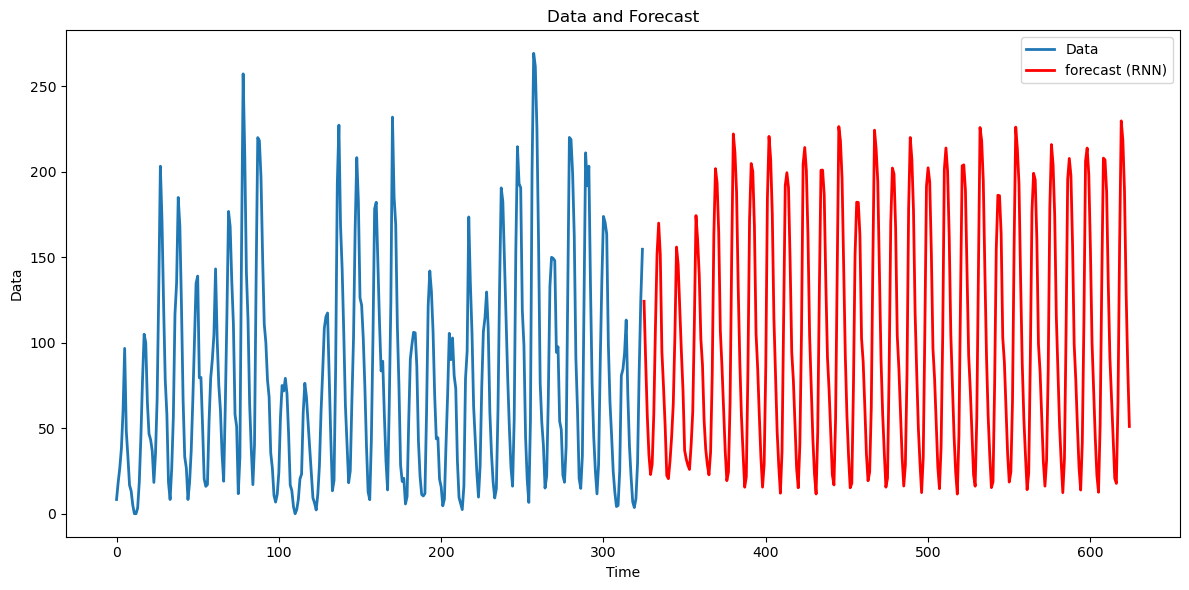

In [299]:
rnn_preds_orig = preds*sig + mu
tme_pred_axis = np.arange(n, n + n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y, lw=2, label="Data")
plt.plot(tme_pred_axis, rnn_preds_orig, lw=2, color="r", label="forecast (RNN)")
plt.xlabel("Time"); plt.ylabel("Data")
plt.title("Data and Forecast")
plt.legend()
plt.tight_layout()
plt.show()

These predictions do not appear as realistic as the LSTM forecasts. 

## GRU for Sunspots

Below we fit the GRU again with 64 hidden units. The code works in exactly the same way as LSTM and RNN.

In [300]:
torch.manual_seed(0)
np.random.seed(0)

nh = 64
class GRUReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(1, nh, batch_first=True)
        self.fc  = nn.Linear(nh,1)
    def forward(self,x,h=None):
        out,h = self.gru(x,h)
        return self.fc(out),h
model = GRUReg()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
lossf = nn.MSELoss()

In [301]:
for epoch in range(1000):
    opt.zero_grad()
    pred,_ = model(X)
    loss = lossf(pred, Y)
    loss.backward(); opt.step()
    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch    0/1000  |  loss = 1.017522
epoch  100/1000  |  loss = 0.193518
epoch  200/1000  |  loss = 0.111449
epoch  300/1000  |  loss = 0.082548
epoch  400/1000  |  loss = 0.063553
epoch  500/1000  |  loss = 0.054251
epoch  600/1000  |  loss = 0.041851
epoch  700/1000  |  loss = 0.056074
epoch  800/1000  |  loss = 0.028392
epoch  900/1000  |  loss = 0.046378


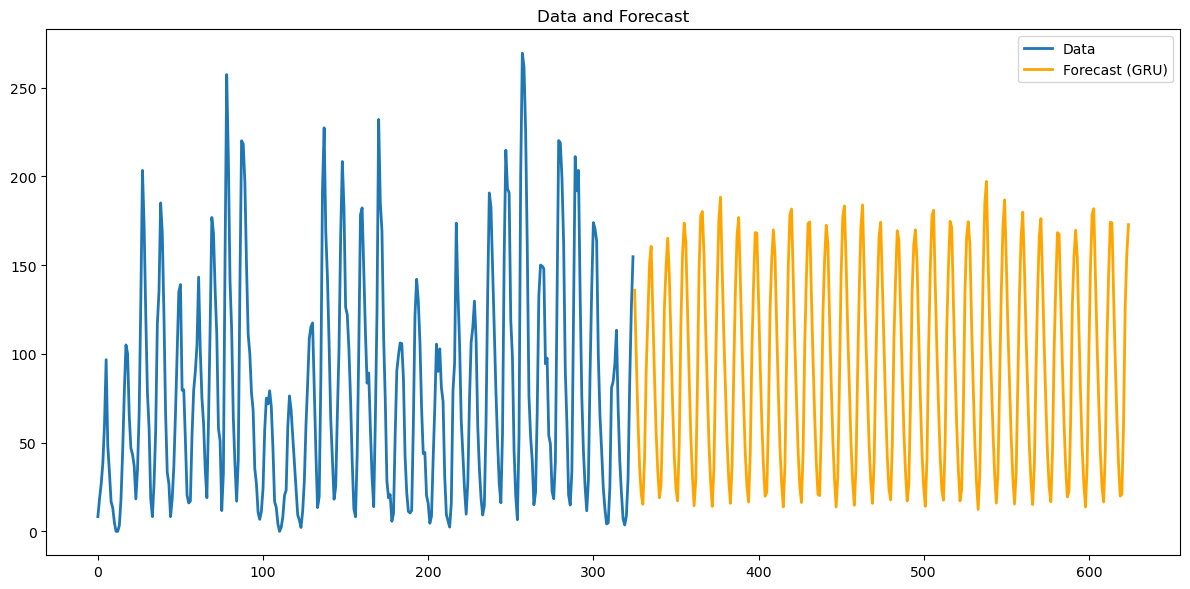

In [302]:
model.eval()
with torch.no_grad():
    _,h = model(X)
    preds = np.zeros(n_future,np.float32)
    last  = torch.tensor([[y_std[-1]]], dtype=torch.float32)
    for t in range(n_future):
        out,h = model(last.view(1,1,1),h)
        preds[t]=out.item()
        last = torch.tensor([[preds[t]]], dtype=torch.float32)

gru_preds_orig = preds*sig+mu
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(y)),y,lw=2,label="Data")
plt.plot(np.arange(len(y),len(y)+n_future),gru_preds_orig, lw=2,label="Forecast (GRU)",color="orange")
plt.legend()
plt.title("Data and Forecast"); plt.legend(); plt.tight_layout(); plt.show()

Again the predictions do not look as realistic as those produced by the LSTM. 

## Simulation Three

The following dataset is simulated according to the model: 
\begin{equation*}
   y_t = 0.9 \sin (0.5\pi y_{t - p}) + \epsilon_t
\end{equation*}
for some fixed $p$. This equation is for $t \geq p+1$. For $t \leq p$, we take $y_t$ to be linear. We take $p$ to be a large value. 

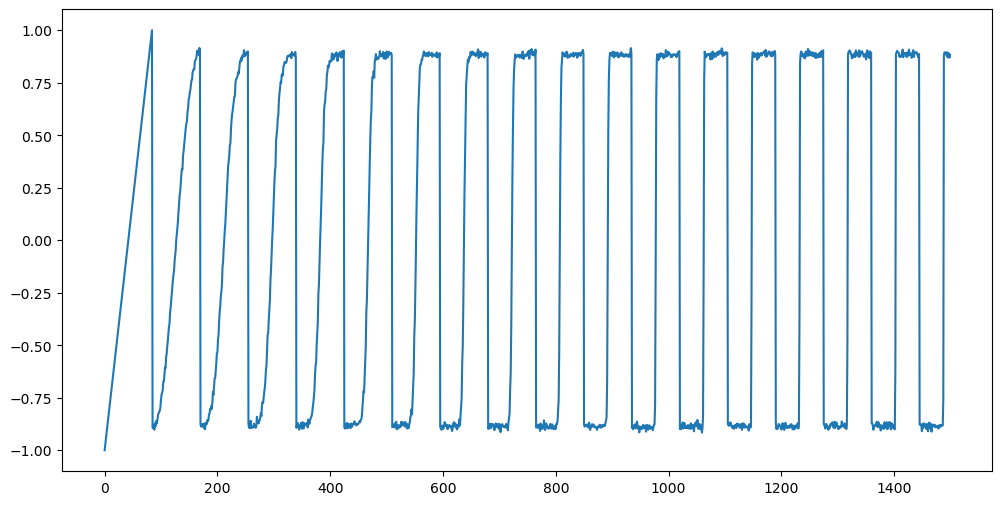

In [303]:
n = 1500
truelag = 85
rng = np.random.default_rng(seed=0)
#sig_noise = 0.05
sig_noise = 0.01

eps = rng.normal(loc=0, scale=sig_noise, size=n)
y_sim = np.full(shape=n, fill_value=-999.0)
y_sim[0:truelag] = np.linspace(-1, 1, truelag)
for i in range(truelag, n):
    y_sim[i] = 0.9 * np.sin(0.5 * np.pi * y_sim[i - truelag]) + eps[i]
#y_sim = y_sim + eps

plt.figure(figsize = (12, 6))
plt.plot(y_sim)
plt.show()

Let us obtain predictions for future values using the actual function $g(y) = 0.9 \sin(0.5 \pi y)$ from which the data were generated. These predictions (which we can refer to as Oracle Predictions) will form the benchmark which we can use to compare the predictions of various methods (AR, LSTM, RNN, GRU).  

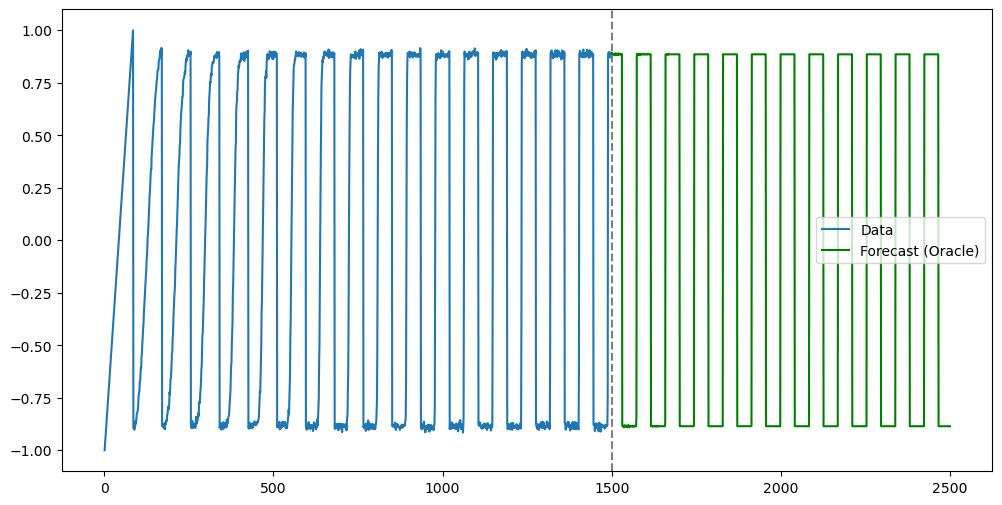

In [304]:
# Oracle Predictions
n_future = 1000
y_extended = np.concatenate([y_sim, np.empty(n_future, dtype=float)])
for t in range(n, n+n_future): 
    y_extended[t] = 0.9 * np.sin(0.5 * np.pi * y_extended[t - truelag])
oracle_preds = y_extended[n:]

n = len(y_sim)
tme = range(1, n+1)
tme_future = range(n+1, n+n_future+1)

plt.figure(figsize = (12, 6))
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, oracle_preds, label = 'Forecast (Oracle)', color = 'green')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

Let us now fit AR(p) to this data. Even if $p$ is taken to be the correct value, this model will not work well (because the actual function which generated the data is nonlinear). 

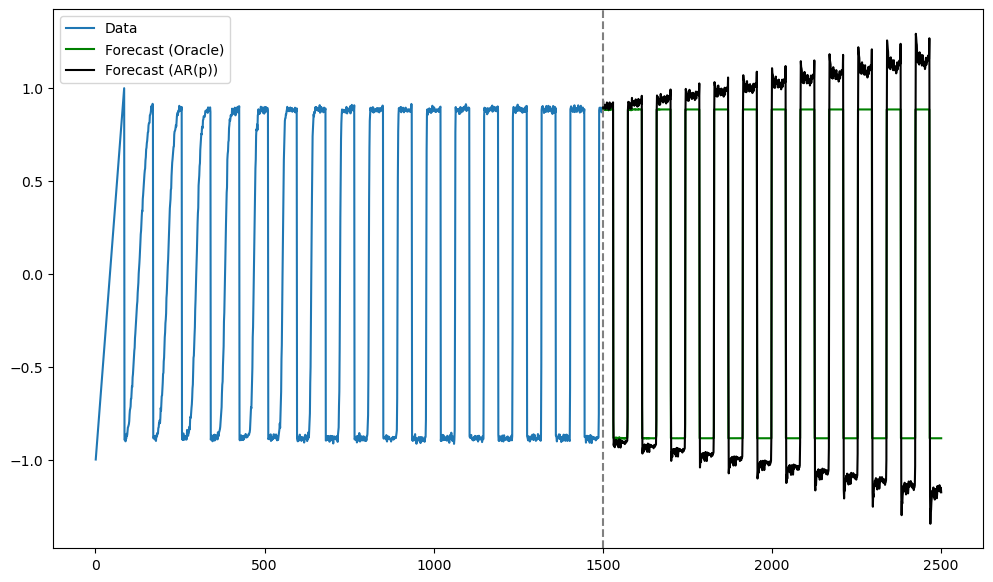

In [305]:
# Let us fit AR(p)
p = truelag
#p = 50
ar = AutoReg(y_sim, lags=p).fit() 

n = len(y_sim)
tme = range(1, n+1)
tme_future = range(n+1, n+n_future+1)
fcast = ar.get_prediction(start=n, end=n+n_future-1).predicted_mean

plt.figure(figsize = (12, 7))
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, oracle_preds, label = 'Forecast (Oracle)', color = 'green')
plt.plot(tme_future, fcast, label = 'Forecast (AR(p))', color = 'black')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

The AR predictions seem to be "expanding" compared to the Oracle predictions. 

Below we calculate the mean square error and median absolute error of the discrepancy between the AR forecasts and the forecasts obtained by using the Oracle function $g$. 

In [306]:
rmse_ar = np.sqrt(np.mean((fcast - oracle_preds)**2))
median_abs_error_ar = np.median(np.abs(fcast - oracle_preds))
print(rmse_ar)
print(median_abs_error_ar)

0.18216756914528376
0.14333472168608313


In [307]:
mu, sig = y_sim.mean(), y_sim.std()
y_std = (y_sim - mu) / sig

X = torch.tensor(y_std[:-1], dtype=torch.float32)
Y = torch.tensor(y_std[1: ], dtype=torch.float32)

X = X.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)
Y = Y.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)

seq_len = X.size(1)
print(seq_len)

1499


The code below fits the LSTM, and uses it to obtain predictions. 

In [308]:
class lstm_net(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=nh, batch_first=True)
        # input_size: the number of features in the input x
        # hidden_size: the number of features in the hidden state h(=r in our notation)
        # batch_first: If True, then the input and output tensors are provided 
        #   as (batch, seq_len, feature) instead of (seq_len, batch, feature).
        #   In our case batch = 1, feature = 1
        self.fc  = nn.Linear(nh, 1)          # many-to-many

    def forward(self, x, hc=None):
        out, hc = self.rnn(x, hc)            
        # out: (batch, seq_len, hidden_size)
        # hc = (h_n, c_n) 
        #   the final hidden state h_n(=r_n) and c_n(=s_n in our notation) 
        #   h_n: (1, hidden_size), c_n: (1, hidden_size)
        out     = self.fc(out)               # (batch, seq_len, 1)
        return out, hc

torch.manual_seed(0)
np.random.seed(0)

nh = 32
model = lstm_net(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [309]:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    #model.train()  # Set the model to training mode
    opt.zero_grad()

    pred, _ = model(X)  # hidden state auto-reset every epoch
    loss = criterion(pred, Y)

    loss.backward()

    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch  100/1000  |  loss = 0.127903
epoch  200/1000  |  loss = 0.090235
epoch  300/1000  |  loss = 0.071659
epoch  400/1000  |  loss = 0.063751
epoch  500/1000  |  loss = 0.067751
epoch  600/1000  |  loss = 0.050256
epoch  700/1000  |  loss = 0.042608
epoch  800/1000  |  loss = 0.038524
epoch  900/1000  |  loss = 0.034826
epoch 1000/1000  |  loss = 0.031501


In [310]:
#model.eval()

with torch.no_grad():
    _, hc = model(X)
    preds = np.zeros(n_future, dtype=np.float32)
    last_in = torch.tensor([[y_std[-1]]], dtype=torch.float32)  # (1, 1, 1) after view

    for t in range(n_future):
        out, hc = model(last_in.view(1, 1, 1), hc)              # reuse hidden state
        next_val = out.squeeze().item()
        preds[t] = next_val
        last_in = torch.tensor([[next_val]], dtype=torch.float32)

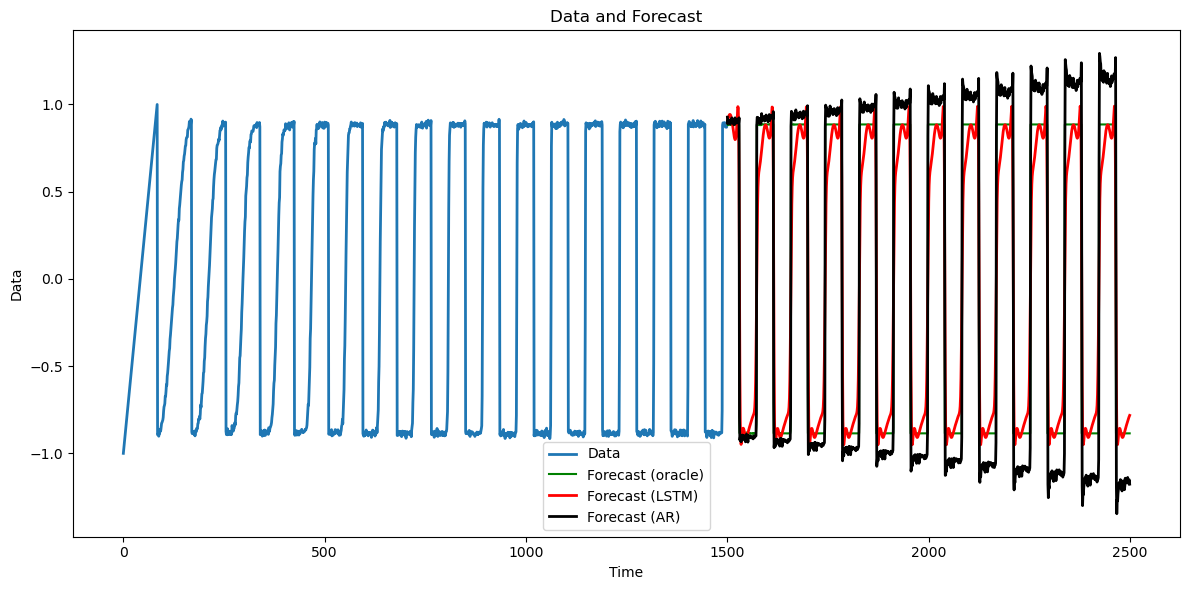

In [311]:
lstm_preds_orig = preds * sig + mu
tme_pred_axis = np.arange(n, n+n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y_sim, lw = 2, label = "Data")
plt.plot(tme_pred_axis, oracle_preds, color = 'green', label = 'Forecast (oracle)')
plt.plot(tme_pred_axis, lstm_preds_orig, lw = 2, color="r", label = "Forecast (LSTM)")
plt.plot(tme_pred_axis, fcast, lw = 2, color = "black", label = "Forecast (AR)")
plt.xlabel("Time"); plt.ylabel("Data")
plt.title("Data and Forecast")
plt.legend()
plt.tight_layout()
plt.show()

Visually the LSTM predictions clearly look better compared to the AR predictions. Below we quantify the discrepancy in predictions compared to the Oracle predictions. 

In [312]:
rmse_lstm = np.sqrt(np.mean((lstm_preds_orig - oracle_preds)**2))
median_abs_error_lstm = np.median(np.abs(lstm_preds_orig - oracle_preds))
print(rmse_ar, rmse_lstm)
print(median_abs_error_ar, median_abs_error_lstm)

0.18216756914528376 0.21048515649384567
0.14333472168608313 0.05856568465625367


Even though the predictions from LSTM are clearly better than those from AR as we can see from the plot above, AR produces smaller RMSE compared to LSTM. This is because the underlying function has many sharp tranisitions, and RMSE is sensitive to outlier error values. Even if LSTM generally performs well over the domain, a few large errors around the transition points can make RMSE larger. To address this issue, we can use more robust evaluation metrics. For example, we can think of using the median of absolute errors as we did above.

Please note that, even if you copy this code exactly and set the same random seeds, you may still get slightly different results on your own computer. This is because different machines use different versions of NumPy, PyTorch, and statsmodels, and these libraries can change how random numbers are generated, how models are fit, or how LSTMs are trained. Small numerical differences—often invisible—can grow during forecasting, especially for neural networks. So the overall behavior will most likely be the same, but the exact numbers may not match perfectly across computers.